<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Deep_Learning_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.models as tfkm
import tensorflow.keras.layers as tfkl
import tensorflow.keras.utils as tfku

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

In [4]:
N, H, W = x_train.shape

In [5]:
class ConvModel(tfk.Model):
    def __init__(self, **kwds):
        inp = tfkl.Input([28, 28])

        x = inp
        x = tfkl.Reshape([28, 28, 1])(x)
        x = tfkl.Rescaling(scale = 1./127.5, offset = -1)(x)

        channels = 1

        for _ in range(5):
            res = x
            x1 = tfkl.DepthwiseConv2D(kernel_size = (3, 1), dilation_rate = (1, 1), padding = 'same')(x)
            x1 = tfkl.DepthwiseConv2D(kernel_size = (1, 3), dilation_rate = (1, 1), padding = 'same')(x1)

            x2 = tfkl.DepthwiseConv2D(kernel_size = (3, 1), dilation_rate = (2, 2), padding = 'same')(x)
            x2 = tfkl.DepthwiseConv2D(kernel_size = (1, 3), dilation_rate = (2, 2), padding = 'same')(x2)

            x3 = tfkl.DepthwiseConv2D(kernel_size = (3, 1), dilation_rate = (3, 3), padding = 'same')(x)
            x3 = tfkl.DepthwiseConv2D(kernel_size = (1, 3), dilation_rate = (3, 3), padding = 'same')(x3)

            x4 = tfkl.DepthwiseConv2D(kernel_size = (3, 3), dilation_rate = (4, 4), padding = 'same')(x)
            x4 = tfkl.DepthwiseConv2D(kernel_size = (1, 3), dilation_rate = (4, 4), padding = 'same')(x4)

            x = tfkl.Concatenate()([x1, x2, x3, x4])

            x = tfkl.BatchNormalization(axis = 3)(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(channels)(x)

            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization(axis = (1, 2))(x)
            x = tfkl.Conv2D(2 * channels, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(x)

            channels *= 2

        x = tfkl.Flatten()(x)
        self.features = x

        x = tfkl.Dense(10)(x)
        out = x

        super(ConvModel, self).__init__(inputs = [inp], outputs = [out])


In [6]:
model = ConvModel()

In [7]:
model.summary()

Model: "conv_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 reshape (Reshape)           (None, 28, 28, 1)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 28, 28, 1)            0         ['reshape[0][0]']             
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 28, 28, 1)            4         ['rescaling[0][0]']           
 eConv2D)                                                                                

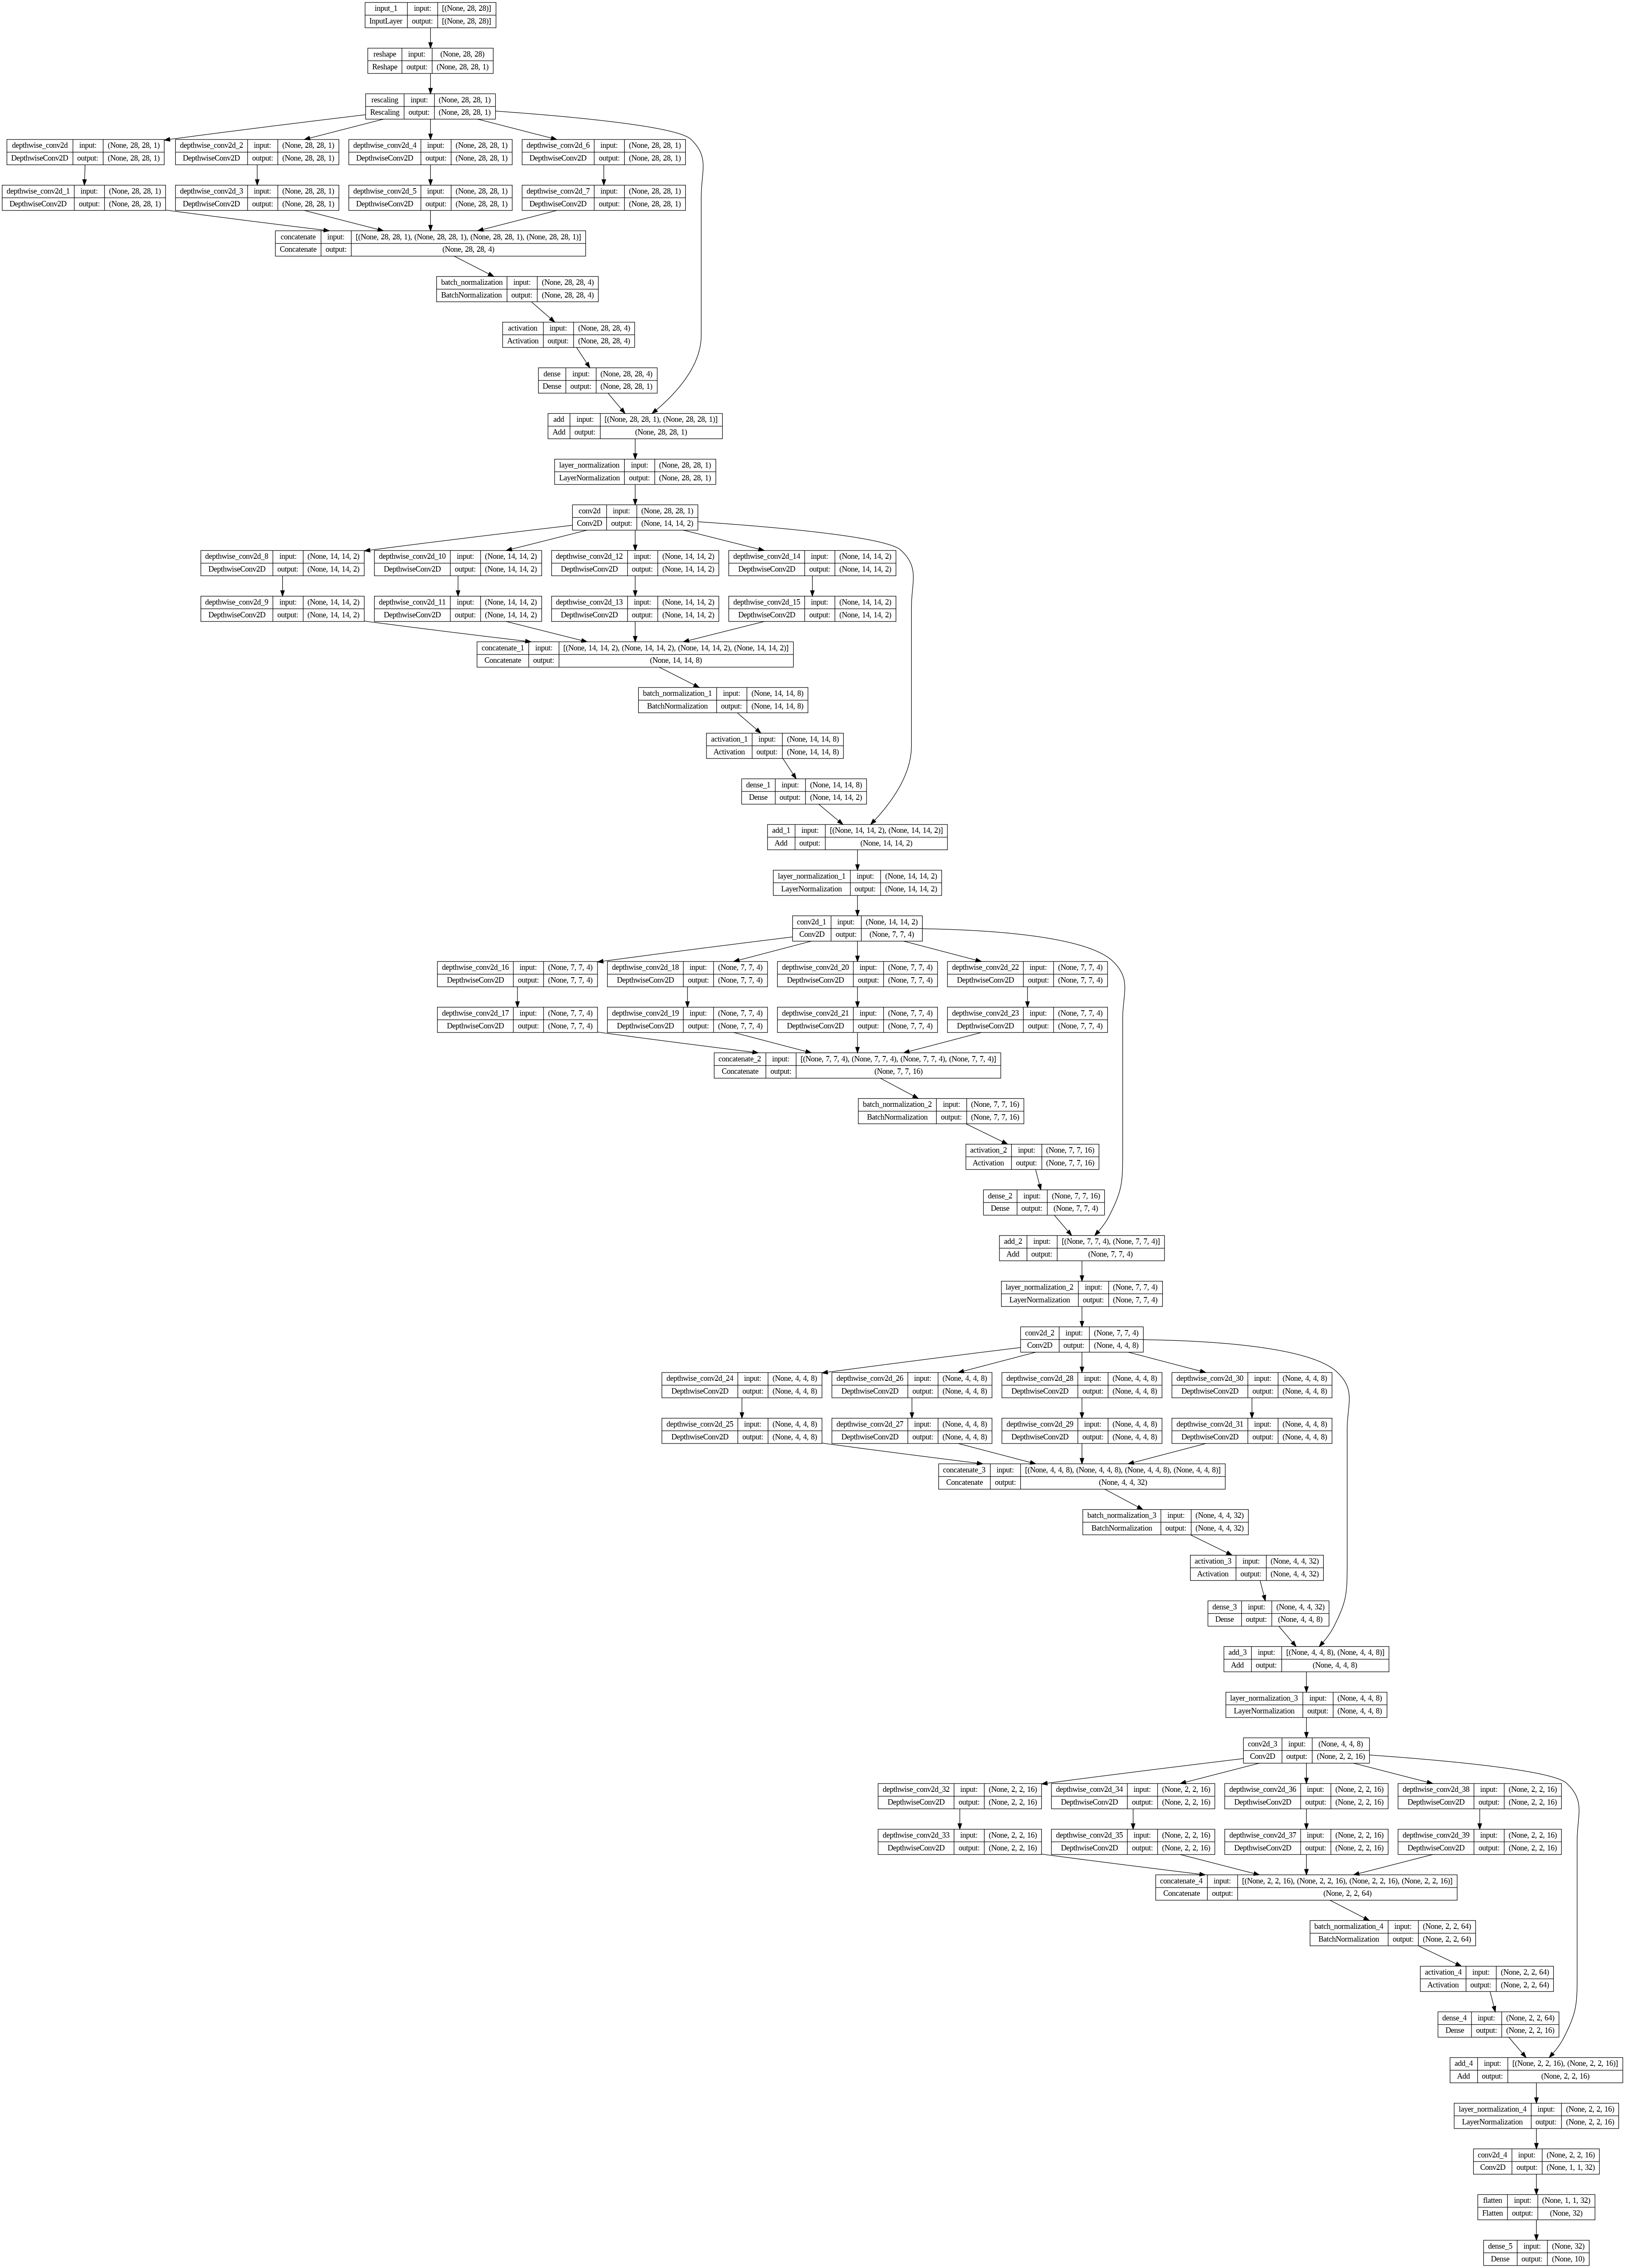

In [8]:
tfku.plot_model(model, show_shapes = True)

In [9]:
def train_fn(batch_size, epochs):
    dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
                       .repeat(epochs)
                       .shuffle(10 * batch_size)
                       .batch(batch_size)
                       .prefetch(4 * batch_size)
    )

    model.compile(
        optimizer = tfk.optimizers.Adam(),
        loss = tfk.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
    )

    model.fit(dataset)

In [10]:
train_fn(8, 4)

30000/30000 [==============================] - 1036s 34ms/step - loss: 0.1753 - accuracy: 0.9455


In [11]:
model.evaluate(x = x_test, y = y_test)

313/313 [==============================] - 13s 37ms/step - loss: 0.1042 - accuracy: 0.9674


[0.10417815297842026, 0.9674000144004822]